# Tropics Temperature Quantile Theory
This notebook looks at trying to recreate the black lines of Figure 2 of Byrne 2021. I.e. it tries to estimate the temperature above a given quantile, given details of the average summer day of that climate in the tropics.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.



In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-31 10:53:40,829 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/evap/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

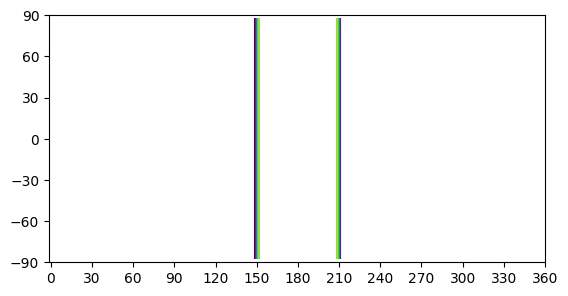

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for extratropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [4]:
## Split datasets into land and ocean ones
ds_all = {'land':[], 'ocean': []}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
for i in range(n_exp):
    for surf in ['land', 'ocean']:
        ds_all[surf] += [ds[i].sel(lon=np.unique(lon[surf]), method='nearest')]

In [7]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
region = 'Tropics'
lat_min = 0
lat_max = 20

temp_summer_av = np.zeros(n_exp)
ds_summer = {'land': [], 'ocean': []}
for i in tqdm(range(n_exp)):
    for surf in ['land', 'ocean']:
        ds_use = ds_all[surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
        ds_summer[surf] += [ds_use]
        ds_summer[surf][i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
    temp_summer_av[i] = ds_summer['ocean'][i].temp[-1]       # Compute average summer temperature from ocean dataset
ds_mean = ds_summer['ocean'] # mean dataset refers to mean summer ocean

100%|██████████| 2/2 [00:44<00:00, 22.40s/it]


In [6]:
# Get data set averaged over all days exceeding every quantile of near surface temperature in extratropics.
# Do this for each optical depth value and each quantile
quantiles_all = np.arange(90, 100)
n_quantiles = len(quantiles_all)
temp_all_quant = {'land': np.zeros((n_exp, n_quantiles)), 'ocean': np.zeros((n_exp, n_quantiles))}
ds_quant = {'land': [[], []], 'ocean': [[], []]}
for i in range(n_exp):
    for surf in ['land', 'ocean']:
        ds_use = ds_all[surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
        # Collapse to single coordinate and then take quantile over it
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        for j in tqdm(range(n_quantiles)):
            quantile_thresh = ds_use.temp[-1].quantile(quantiles_all[j]/100, dim='lon_lat_time', keep_attrs=True)
            # Average each variable in data over days where near surface temperature exceeds this quantile
            ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
            ds_quant[surf][i] += [ds_use2]
            ds_quant[surf][i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

            # Record mean extratropical near surface temperature
            temp_all_quant[surf][i, j] = ds_quant[surf][i][j].temp[-1]

100%|██████████| 10/10 [04:03<00:00, 24.37s/it]


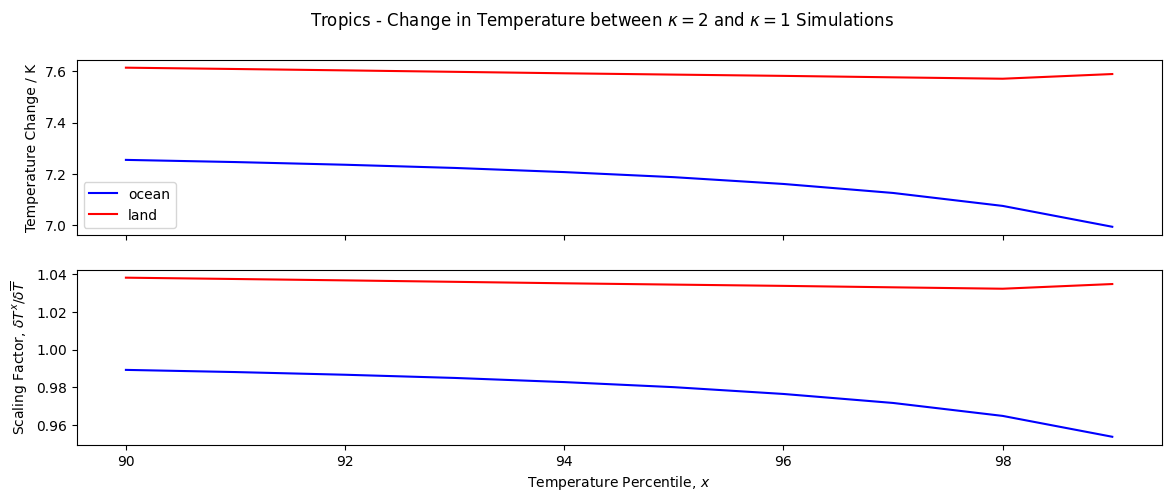

In [8]:
# In second plot here, normalise by change in the summer mean temperature
plt_color = {'land': 'red', 'ocean': 'blue'}
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
temp_diff_quant = {'land': [], 'ocean':[]}
for surf in ['ocean', 'land']:
    temp_diff_quant[surf] = temp_all_quant[surf][1]-temp_all_quant[surf][0]
    ax[0].plot(quantiles_all, temp_diff_quant[surf], label=surf, color=plt_color[surf])
    ax[1].plot(quantiles_all, temp_diff_quant[surf]/(temp_summer_av[1] - temp_summer_av[0]), label=surf, color=plt_color[surf])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$
This is trying to get a theory for the change in temperature of a given percentile day in a manor analagous to byrne 2021.

In [9]:
p_surface = float(ds_mean[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_surface_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_surface)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
# Initially thought should use the mid point for this but actually in taylor series, you evaluate at lowest (k=1) value.,
# temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_mean_mid = temp_summer_av[0]
# temp_quant_mid = np.mean(temp_all_quant, axis=0)
temp_quant_mid = {surf: temp_all_quant[surf][0] for surf in temp_all_quant.keys()}

In [10]:
# Compute constants required for theory
alpha_quant = {surf: clausius_clapeyron_factor(temp_quant_mid[surf]) for surf in ['land', 'ocean']}
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = {surf: np.asarray([np.asarray([ds_quant[surf][i][j].sphum[-1] for j in range(n_quantiles)]) for i in range(n_exp)])
           for surf in ['land', 'ocean']}
q_quant_mid = {surf: q_quant[surf][0] for surf in ['land', 'ocean']}
rh_quant = {surf: rh_from_sphum(q_quant[surf],temp_all_quant[surf],p_surface)/100 for surf in ['land', 'ocean']}

# Mean values refer to summer ocean mean
q_mean = np.asarray([ds_mean[i].sphum[-1] for i in range(n_exp)])
# q_mean_mid = np.mean(q_mean)
q_mean_mid = q_mean[0]
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_surface)/100

q_sat_quant = {surf: sphum_surface_sat(temp_quant_mid[surf]) for surf in ['land', 'ocean']}
q_sat_mean = sphum_surface_sat(temp_mean_mid)

delta_rh_quant = {surf: rh_quant[surf][1] - rh_quant[surf][0] for surf in ['land', 'ocean']}
delta_t_mean = temp_summer_av[1] - temp_summer_av[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]

In [11]:
surf_use = 'land'   # only compute stuff for this surface
# Change 1 to 0 to leave out the drdT terms below, but they are important I think
denom = c_p + L_v * alpha_quant[surf_use] * (q_quant_mid[surf_use] + 1 * q_sat_quant[surf_use] * delta_rh_quant[surf_use])
gamma_t = (c_p + L_v * alpha_mean * (q_mean_mid + 1 * q_sat_mean * delta_rh_mean))/denom
gamma_t_zero_rh = (c_p + L_v * alpha_mean * q_mean_mid)/(c_p + L_v * alpha_quant[surf_use] * q_quant_mid[surf_use])
gamma_r = L_v * q_sat_mean / denom
gamma_r_quant = -L_v * q_sat_quant[surf_use] / denom
gamma_mse = 1 / denom

In [12]:
# Compute the delta h* term based on the saturation MSE in the free troposphere
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

mse_quant = np.zeros((n_exp, n_quantiles))
mse_ft_sat_quant = np.zeros((n_exp, n_quantiles))
mse_summer = np.zeros(n_exp)
mse_ft_sat_summer = np.zeros(n_exp)
for i in range(n_exp):
    mse_summer[i] = moist_static_energy(ds_mean[i].temp[-1], ds_mean[i].sphum[-1], ds_mean[i].height[-1])
    mse_ft_sat_summer[i] = mse_ft(ds_mean[i])
    for j in range(n_quantiles):
        mse_quant[i, j] = moist_static_energy(ds_quant[surf_use][i][j].temp[-1], ds_quant[surf_use][i][j].sphum[-1],
                                              ds_quant[surf_use][i][j].height[-1])
        mse_ft_sat_quant[i, j] = mse_ft(ds_quant[surf_use][i][j])

mse_sat_diff = mse_ft_sat_quant - mse_ft_sat_summer.reshape(-1, 1)
delta_mse_sat_diff = (mse_sat_diff[1] - mse_sat_diff[0]) * 1000   # *1000 so in units of J/kg

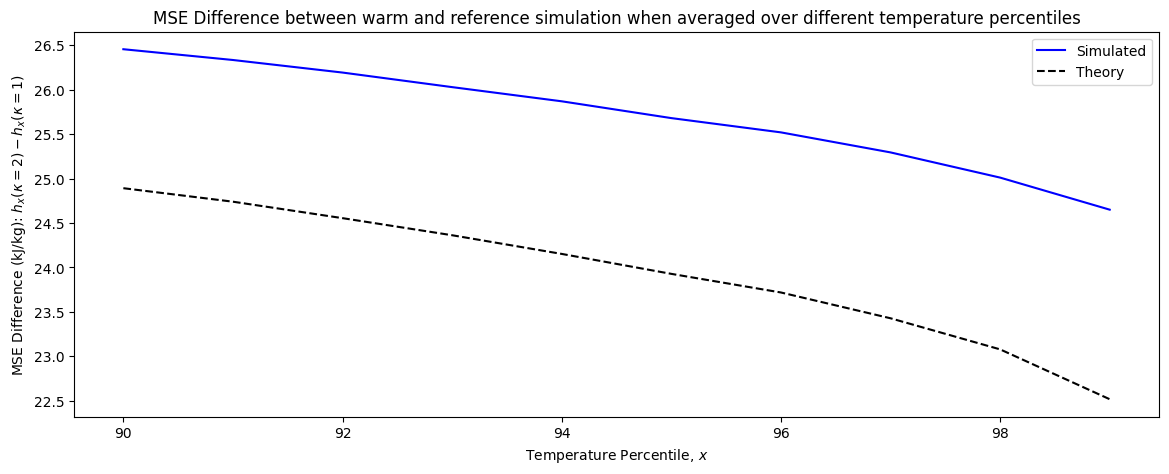

In [13]:
## Compare predicted MSE difference to that from the theory
mse_quant_diff = (c_p * temp_diff_quant[surf_use] + L_v * (q_quant[surf_use][1]-q_quant[surf_use][0])) / 1000
mse_quant_diff_sim = (c_p * (temp_summer_av[1]-temp_summer_av[0]) + L_v * (q_mean[1]-q_mean[0]))/1000 + mse_sat_diff[1]-mse_sat_diff[0]

fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quantiles_all, mse_quant_diff, color='blue', label='Simulated')
ax.plot(quantiles_all, mse_quant_diff_sim, color='k', linestyle='--', label='Theory')
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_ylabel(f'MSE Difference (kJ/kg): $h_x(\kappa={tau_lw_warm})-h_x(\kappa={tau_lw_ref})$')
ax.set_title('MSE Difference between warm and reference simulation when averaged over different temperature percentiles')
ax.legend();

There is a fairly large difference between the theory and simulation above. This is because in the $\kappa=2$ simulation, the assumption of convective neutrality is incorrect; and it differs more from the moist adiabat as $x$ increases.

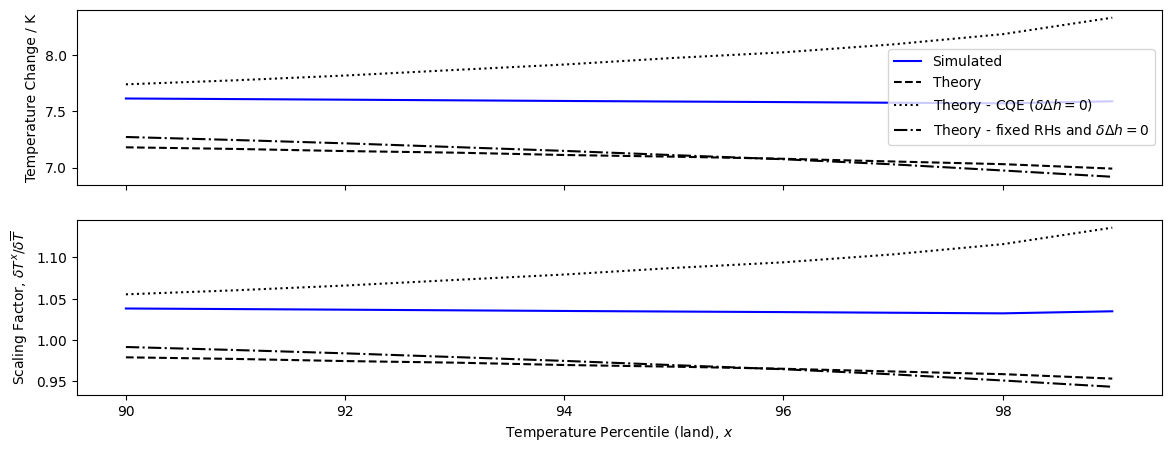

In [14]:
# Compared predicted temperature difference - Figure 2 of byrne 2021
temp_diff_theory = gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant[surf_use] + \
                   gamma_mse * delta_mse_sat_diff
temp_diff_theory_cqe = gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant[surf_use]
temp_diff_theory_const_rh = gamma_t_zero_rh*delta_t_mean
# Consider adding non-linear term to theory temperature
# temp_diff_theory = temp_diff_theory + prefactor * gamma_nl * delta_rh_mean * delta_t_mean
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant[surf_use], color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory')
ax[0].plot(quantiles_all, temp_diff_theory_cqe, color='k', linestyle=':', label='Theory - CQE ($\delta \Delta h = 0$)')
ax[0].plot(quantiles_all, temp_diff_theory_const_rh, color='k', linestyle='-.', label='Theory - fixed RHs and $\delta \Delta h = 0$')
ax[1].plot(quantiles_all, temp_diff_quant[surf_use]/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory_cqe/ (temp_summer_av[1] - temp_summer_av[0]),
           color='k', linestyle=':', label='Theory - CQE ($\delta \Delta h = 0$)')
ax[1].plot(quantiles_all, temp_diff_theory_const_rh / (temp_summer_av[1] - temp_summer_av[0]),
           color='k', linestyle='-.', label='Theory - fixed RHs and $\Delta h = 0$')
ax[1].set_xlabel(f'Temperature Percentile ({surf_use}), $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Breakdown the contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases.

It is basically replicating Figure 4 of Byrne 2021.

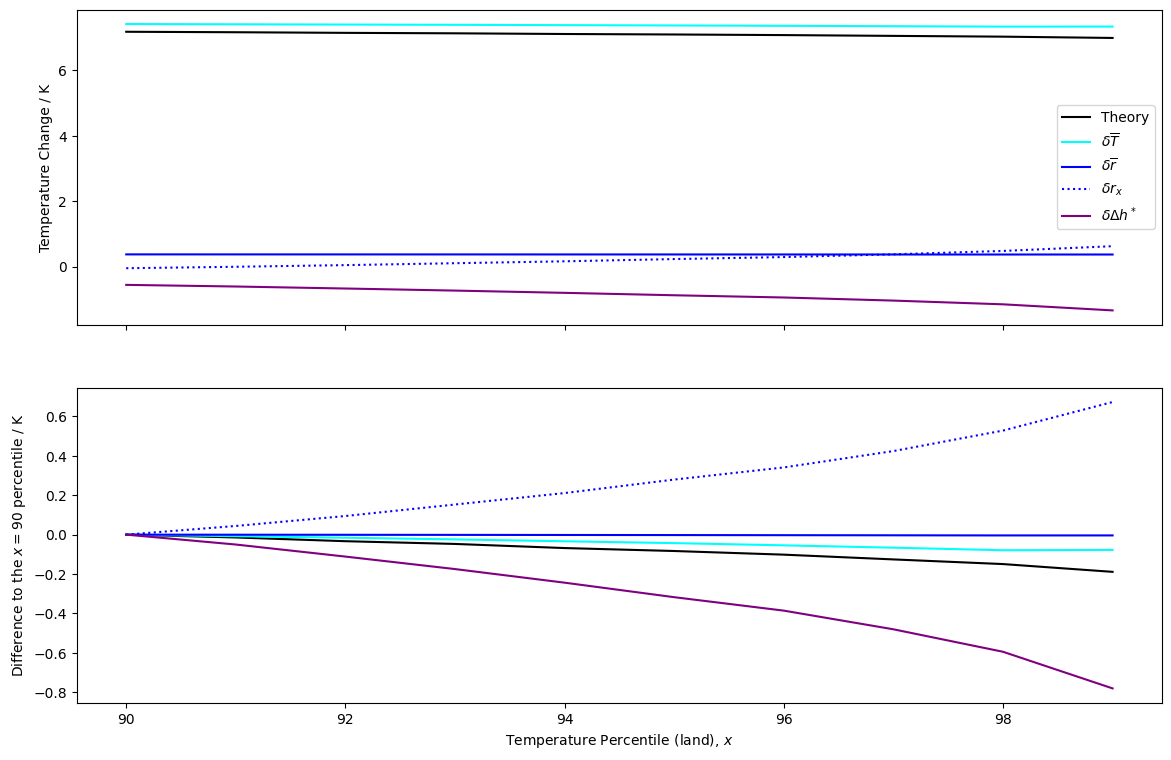

In [15]:
temp_diff_terms = [gamma_t * delta_t_mean, gamma_r * delta_rh_mean, gamma_r_quant * delta_rh_quant[surf_use], gamma_mse * delta_mse_sat_diff]
temp_diff_terms = [term for term in temp_diff_terms]
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, temp_diff_theory, color='k', label='Theory')
ax[0].plot(quantiles_all, temp_diff_terms[0], color='cyan', label='$\delta \overline{T}$')
ax[0].plot(quantiles_all, temp_diff_terms[1], color='blue', label='$\delta \overline{r}$')
ax[0].plot(quantiles_all, temp_diff_terms[2], color='blue', label='$\delta r_x$', linestyle=':')
ax[0].plot(quantiles_all, temp_diff_terms[3], color='purple', label='$\delta \Delta h^*$')

ax[1].plot(quantiles_all, temp_diff_theory - temp_diff_theory[0], color='k', label='Theory')
ax[1].plot(quantiles_all, temp_diff_terms[0]-temp_diff_terms[0][0], color='cyan', label='$\delta \overline{T}$')
ax[1].plot(quantiles_all, temp_diff_terms[1]-temp_diff_terms[1][0], color='blue', label='$\delta \overline{r}$')
ax[1].plot(quantiles_all, temp_diff_terms[2]-temp_diff_terms[2][0], color='blue', label='$\delta r_x$', linestyle=':')
ax[1].plot(quantiles_all, temp_diff_terms[3]-temp_diff_terms[3][0], color='purple', label='$\delta \Delta h^*$')

ax[1].set_xlabel(f'Temperature Percentile ({surf_use}), $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / K')
ax[0].legend();

So from the above plots, the fact that the mean temperature contribution $\delta \overline{T}$ is the dominant effect. The relative humidities don't really do anything and the moist static energy increases as temperature percentile increases, but this increase is dominated by the $\delta \overline{T}$ effect.

To investigate this further, I plot how the sensitivities ($\gamma$ factors) vary with percentile, in plots analagous to Extended data Figure 4 of Byrne 2021:

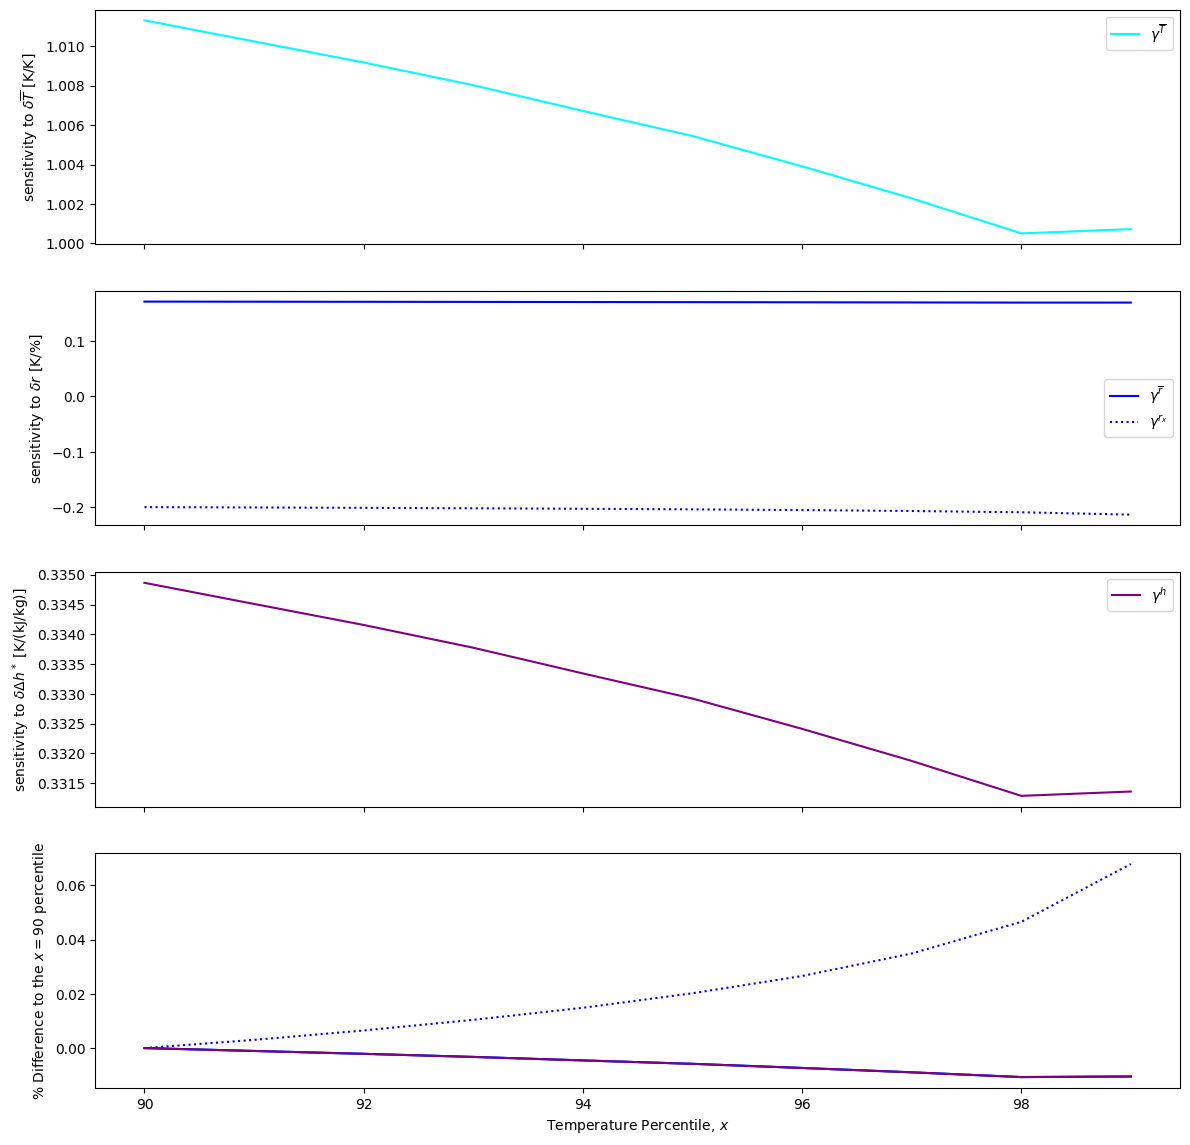

In [16]:
fig, ax = plt.subplots(4,1, figsize=(14, 14), sharex=True)
ax[0].plot(quantiles_all, gamma_t, color='cyan', label='$\gamma^{\overline{T}}$')
ax[0].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
ax[0].legend()

ax[1].plot(quantiles_all, gamma_r/100, color='blue', label='$\gamma^{\overline{r}}$')
ax[1].plot(quantiles_all, gamma_r_quant/100, color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[1].set_ylabel('sensitivity to $\delta r$ [K/%]')
ax[1].legend()

ax[2].plot(quantiles_all, gamma_mse * 1000, color='purple', label='$\gamma^{h}$')
ax[2].set_ylabel('sensitivity to $\delta \Delta h^*$ [K/(kJ/kg)]')
ax[2].legend()

ax[3].plot(quantiles_all, (gamma_t-gamma_t[0])/gamma_t[0], color='cyan', label='$\gamma^{\overline{T}}$')
ax[3].plot(quantiles_all, (gamma_r-gamma_r[0])/gamma_r[0], color='blue', label='$\gamma^{\overline{r}}$')
ax[3].plot(quantiles_all, (gamma_r_quant-gamma_r_quant[0])/gamma_r_quant[0], color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[3].plot(quantiles_all, (gamma_mse-gamma_mse[0])/gamma_mse[0], color='purple', label='$\gamma^{h}$')
ax[3].set_ylabel(f'% Difference to the $x={quantiles_all[0]}$ percentile')
ax[3].set_xlabel('Temperature Percentile, $x$');

From this, wee see that the sensitivity to the mean summer temperature (first plot) shows the opposite behaviour here to that in byrne 2021, where the sensitivity increases with percentile.

The sensitivity to relative humidity on hot days (orange) here behaves approximately the same way as sensitivity to land relative humidity in byrne 2021. But here, the sensitivity to relative humidity on the average summer day (blue line) decreases whereas the analagous parameter in byrne 2021 increases with $x$.

We also see that the sensitivity to the moist static energy difference decreases with $x$.

## Theory for $\gamma^T$

From the above plots, it seems like the main contribution to the change in temperature on days exceeding percentile $x$ is due to the change in the mean temperature i.e. the $\gamma^T \delta \overline{T}$ contribution.

Here we assume constant relative humidity, $\delta r_x = \delta \overline{r} = 0$, in the definition of $\gamma^T$ as is simpler and did a good job at predicting $\delta T_x$.

If we next assume that the difference between the mean and $x$ day temperature ($\Delta T_x = T_x - \overline{T}$) and relative humidity ($\Delta r_x = r_x - \overline{r}$) are small, we can do a taylor expansion of $\gamma^T$.

The results of this are shown below as the theory value.

From this taylor expansion, we can say that for $\gamma^T > 1$ so the temperature of day $x$ increases more than the average day, we require:
$$
-\frac{\Delta r_x}{\Delta T_x} > (\overline{\alpha} - \frac{2}{\overline{T}}) \overline{r}
$$

where $\alpha = \frac{L_v}{R_v \bar{T}^2}$ is the Clausius-Clapeyron parameter.

The left hand side indicates the required drying per kelvin (denominator always positive) and the right hand side is always positive. So what this is saying is that the mean day must have larger relative humidity than the day $x$ day and the difference must exceed a threshold, $(\overline{\alpha} - \frac{2}{\overline{T}}) \overline{r}$, which depends on properties of the mean climate.

I.e. there is a threshold drying for the hottest day to increase faster than the mean. For this dataset, the threshold value is $0.037$ but the actual drying rate has a maximum value of $0.013$ for $x=90$ and decreases to $0.00999$ for $x=99$. Hence we see that $\delta T_x$ decreases with $x$ because the drying rate decreases.


Threshold drying rate = 0.03369366118257312
Actual drying rate = 
[0.02885056 0.02771386 0.02653119 0.0252667  0.02406381 0.02281544
 0.02175399 0.02053795 0.01929403 0.0184897 ]


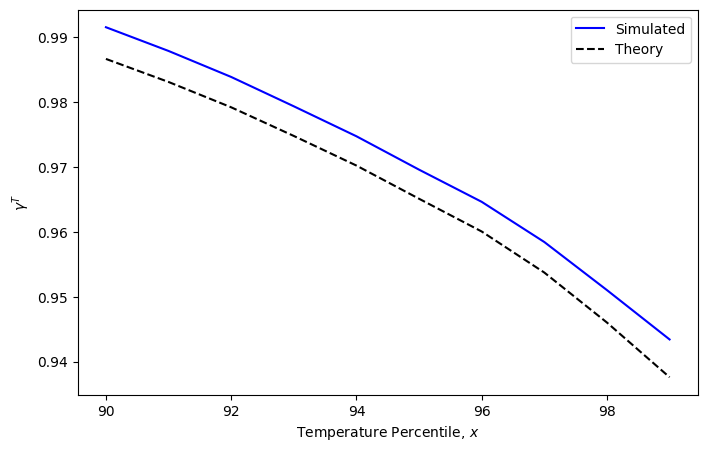

In [17]:
# Get theoretical value of gamma_t with zero RH changes, by doing a taylor expansion assuming
# difference of rh and temp of day x from mean day is small - the temp_surface_diff and rh_surface_diff terms are small
rh_surface_diff = rh_quant[surf_use] - rh_mean.reshape(-1, 1)
temp_surface_diff = temp_all_quant[surf_use] - temp_summer_av.reshape(-1, 1)

gamma_t_zero_rh_theory_prefactor = L_v * alpha_mean * q_sat_mean / (c_p + L_v * alpha_mean * q_mean_mid)
gamma_t_zero_rh_theory_temp_term = - gamma_t_zero_rh_theory_prefactor * (alpha_mean - 2 / temp_mean_mid) * rh_mean[0] * temp_surface_diff[0]
gamma_t_zero_rh_theory_rh_term = - gamma_t_zero_rh_theory_prefactor * rh_surface_diff[0]
gamma_t_zero_rh_theory = 1 + gamma_t_zero_rh_theory_temp_term + gamma_t_zero_rh_theory_rh_term

fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
ax.plot(quantiles_all, gamma_t_zero_rh, color='blue', label='Simulated')
ax.plot(quantiles_all, gamma_t_zero_rh_theory, color='k', linestyle='--', label='Theory')
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_ylabel('$\gamma^T$')
ax.legend()
print(f'Threshold drying rate = {(alpha_mean - 2 / temp_mean_mid) * rh_mean[0]}')
print(f'Actual drying rate = \n{-rh_surface_diff[0]/temp_surface_diff[0]}')

### Breakdown of $\gamma^T$ contributions
The absolute value of $\gamma^T$ is larger for the tropics compared to the extratropics because the $\Delta T_x$ term is smaller (varies from 0.9K to 2K in tropics compared to 5.8K to 7.8K in the extratropics).

The relative humidity and temperature contributions are shown explicitly below.

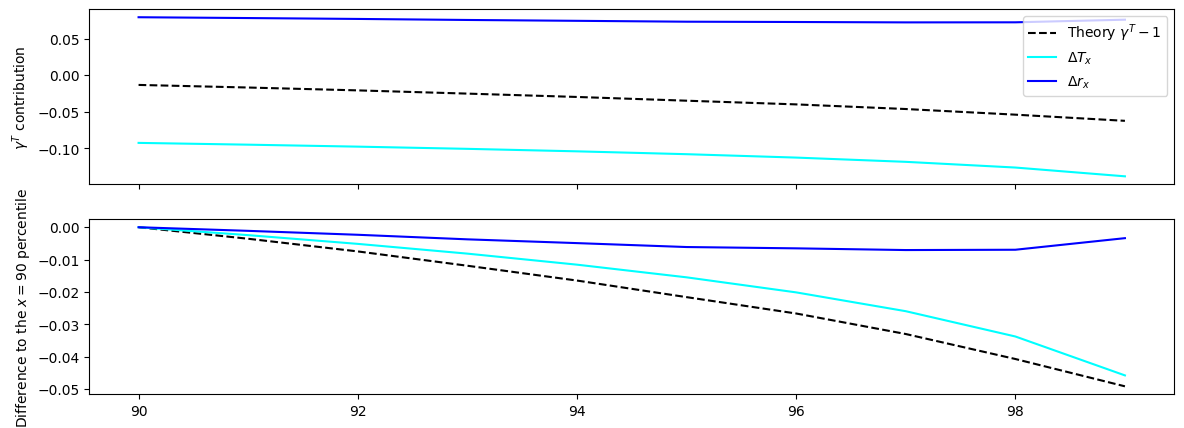

In [18]:
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory - 1, color='k', label='Theory $\gamma^T - 1$', linestyle='--')
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory_temp_term, color='cyan', label='$\Delta T_x$')
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory_rh_term, color='blue', label='$\Delta r_x$')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory - gamma_t_zero_rh_theory[0], color='k', label='Theory $\gamma^T - 1$', linestyle='--')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory_temp_term - gamma_t_zero_rh_theory_temp_term[0],
           color='cyan', label='$\Delta T_x$')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory_rh_term - gamma_t_zero_rh_theory_rh_term[0],
           color='blue', label='$\Delta r_x$')
# ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('$\gamma^T$ contribution')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile')
ax[0].legend();